# Library Imports

In [1]:
import re
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

# IGC Parsing

The first step is to extract the raw data from the IGC file and use it to calculate derived data series of relevance (e.g. climb rate, glide ratio etc.)

**NOTE:** this shows the end result and was iteratively built from the exploration section

In [2]:
def parse_igc(file_path,
              avg_window=15):
    
    # Convert IGC DDDMMmmm or DDMMmmm format to decimal degrees.
    def igc_to_decimal(igc_coordinate, direction):
        # Extract degrees, minutes, and thousandths of a minute
        if len(igc_coordinate) == 7:  # Latitude: DDMMmmm
            degrees = int(igc_coordinate[:2])
            minutes = int(igc_coordinate[2:4])
            thousandths = int(igc_coordinate[4:])
        elif len(igc_coordinate) == 8:  # Longitude: DDDMMmmm
            degrees = int(igc_coordinate[:3])
            minutes = int(igc_coordinate[3:5])
            thousandths = int(igc_coordinate[5:])
        else:
            raise ValueError("Invalid IGC coordinate format. Must be 7 or 8 characters.")

        # Convert to decimal degrees
        decimal_degrees = float(degrees + (minutes + thousandths / 1000) / 60)

        # Apply negative sign for South or West directions
        if direction in ['S', 'W']:
            decimal_degrees *= -1

        return decimal_degrees
    
    # Heading calculation between two points
    def calculate_heading(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        
        # Difference in longitude
        delta_lon = lon2 - lon1
        
        # Calculate initial bearing
        x = math.sin(delta_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
        initial_bearing = math.atan2(x, y)
        
        # Convert from radians to degrees
        initial_bearing = math.degrees(initial_bearing)
        
        # Normalize to 0-360
        compass_bearing = (initial_bearing + 360) % 360
        
        return compass_bearing

    # Rate of change of heading calculation
    def heading_delta(rolling_input):
        rolling_input = list(rolling_input)

        # Adjust for 360 degree rollover, left turn
        if abs(rolling_input[0]>300) & abs(rolling_input[1]<60):
            return  (360+rolling_input[1]) - rolling_input[0]
        
        # Adjust for 360 degree rollover, right turn
        elif abs(rolling_input[0]<60) & abs(rolling_input[1]>300):
            return  (rolling_input[1]-360) - rolling_input[0]
        
        else :
            return rolling_input[1] - rolling_input[0]
    
    # Ground speed based on lat/lon
    def calculate_ground_speed(lat1, lon1, lat2, lon2, time_diff_seconds=1):
        # Radius of Earth in meters
        R = 6371000  

        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

        # Calculate differences
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1

        # Haversine formula
        a = math.sin(delta_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(delta_lon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance_meters = R * c  # Distance in meters

        # Calculate ground speed (distance / time)
        ground_speed = distance_meters / time_diff_seconds if time_diff_seconds > 0 else 0

        return ground_speed

    # Calculate subparameters with the rolling average window (average climb rates, glide ratio, and flight states)
    def calculate_rolling_subparams(window_data):
        # Average climb rates
        avg_gps_climb_rate = window_data['gps_climb_rate'].mean()
        avg_baro_climb_rate = window_data['baro_climb_rate'].mean()

        # Flight state calculations and conditional logic
        avg_ground_speed = window_data['ground_speed'].mean()
        avg_heading_roc = window_data['heading_roc'].mean()
        abs_avg_heading_roc = abs(avg_heading_roc)

        if avg_baro_climb_rate > 0 and abs_avg_heading_roc >= 10 :
            flight_state = 2.0  # Thermal
        elif abs_avg_heading_roc < 10 and avg_ground_speed > 3 :
            flight_state = 1.0  # Glide
        else:
            flight_state = 0.0  # Undefined
        
        # Calculate glide ratio
        glide_ratio = abs(avg_ground_speed / avg_gps_climb_rate) if avg_gps_climb_rate < 0 else 1000000

        return avg_heading_roc, avg_ground_speed, avg_gps_climb_rate, avg_baro_climb_rate, flight_state, glide_ratio

    # Open IGC file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Read each B-record in the IGC file and extract the corresponding information
    fixes = []
    for line in lines:
        if line.startswith("B"):
            timestamp = line[1:7]
            lat = igc_to_decimal(line[7:14], line[14:15])
            lon = igc_to_decimal(line[15:23], line[23:24])
            gps_alt = line[25:30]
            bar_alt = line[30:35]
            
            fixes.append([timestamp, lat, lon, gps_alt, bar_alt])
    
    # Create a DataFrame from the extracted raw information
    df = pd.DataFrame(fixes, columns=["time", 
                                      "latitude", 
                                      "longitude",  
                                      "gps_altitude", 
                                      "baro_altitude"
                                      ])
    df["latitude"] = df["latitude"].astype(float)
    df["longitude"] = df["longitude"].astype(float)
    df["gps_altitude"] = df["gps_altitude"].astype(float)
    df["baro_altitude"] = df["baro_altitude"].astype(float)

    # Calculate ground speed, heading, and rate of change of heading
    df['ground_speed'] = df.apply(lambda row: calculate_ground_speed(row['latitude'], row['longitude'],
                                                                     df.loc[row.name + 1, 'latitude'] if row.name + 1 < len(df) else row['latitude'],
                                                                     df.loc[row.name + 1, 'longitude'] if row.name + 1 < len(df) else row['longitude']
                                                                     ), axis=1
                            ).astype(float)
    df['heading'] = df.apply(lambda row: calculate_heading(row['latitude'], row['longitude'],
                                                           df.loc[row.name + 1, 'latitude'] if row.name + 1 < len(df) else row['latitude'],
                                                           df.loc[row.name + 1, 'longitude'] if row.name + 1 < len(df) else row['longitude']
                                                           ), axis=1
                            ).astype(float)
    df['heading_roc'] = df['heading'].rolling(window=2).apply(heading_delta,raw=False).astype(float)

    # Calculate climb rates
    df['gps_climb_rate'] = df['gps_altitude'].diff().astype(float)
    df['baro_climb_rate'] = df['baro_altitude'].diff().astype(float)
    
    # Calculate average climb rates and determine flight states per provided or standard rolling window size
    df = pd.concat([df, 
                    pd.DataFrame([calculate_rolling_subparams(df[['ground_speed','heading_roc','gps_climb_rate','baro_climb_rate']].iloc[max(0, i - avg_window + 1):i + 1])
                                if i >= avg_window - 1 else (np.nan, np.nan, np.nan)
                                for i in range(len(df))], 
                    columns=['avg_heading_roc', 'avg_ground_speed', 'avg_gps_climb_rate', 'avg_baro_climb_rate', 'flight_state','glide_ratio'])], 
                    axis=1)
    
    return df

# Exploration

In [3]:
df = parse_igc("../data/raw/igc/rmfalquier.2024-08-31.10-43-13.IGC")
df

,time,latitude,longitude,gps_altitude,baro_altitude,ground_speed,heading,heading_roc,gps_climb_rate,baro_climb_rate,avg_heading_roc,avg_ground_speed,avg_gps_climb_rate,avg_baro_climb_rate,flight_state,glide_ratio
0,104300,46.658233,8.054550,1985.0,2133.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104301,46.658233,8.054550,1985.0,2133.0,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,104302,46.658233,8.054550,1985.0,2133.0,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,104303,46.658233,8.054550,1985.0,2133.0,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,104304,46.658233,8.054550,1985.0,2133.0,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12952,141854,46.680733,7.823533,501.0,570.0,0.000000,0.000000,0.000000,0.0,0.0,-15.983749,1.253298,-0.333333,-0.466667,0.0,3.759894
12953,141855,46.680733,7.823533,501.0,570.0,0.000000,0.000000,0.000000,0.0,0.0,-16.916509,0.811842,-0.266667,-0.333333,0.0,3.044407
12954,141856,46.680733,7.823533,501.0,570.0,0.000000,0.000000,0.000000,0.0,0.0,-16.272437,0.529128,-0.200000,-0.200000,0.0,2.645638
12955,141857,46.680733,7.823533,501.0,570.0,1.271445,89.999994,89.999994,0.0,0.0,-9.594373,0.404120,-0.066667,-0.133333,0.0,6.061803


### Heading information

- The first plot (heading) already showed a clear distinction between gliding state and climbing state based on the stability of the heading value
- The second plot (rate of change of heading) showed that there appears to be a band between abs(0, 10) degrees per second that distinguishes gliding from other states
- The third plot (normalized histogram of rate of change of heading) shows a somewhat normally distributed distribution of the rate across the flight with a slight bias for left turns

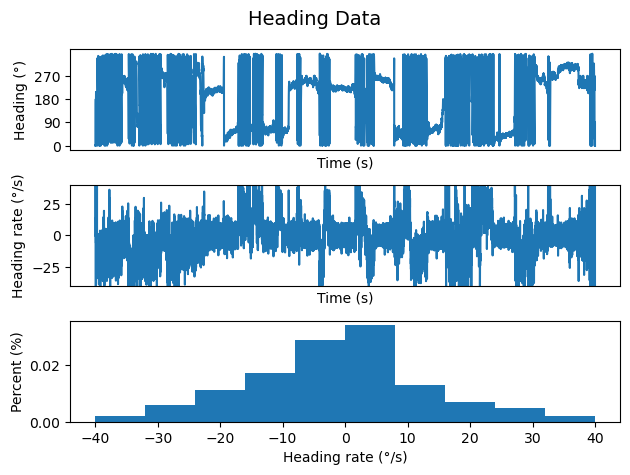

In [17]:
fig_hdg,ax_hdg = plt.subplots(3)
ax_hdg[0].set_xticks([])
ax_hdg[0].plot(df['time'],df['heading'])
ax_hdg[0].set_yticks(range(0,360,90))
ax_hdg[0].set_ylabel('Heading (°)')
ax_hdg[0].set_xlabel('Time (s)')

ax_hdg[1].set_xticks([])
ax_hdg[1].plot(df['time'],df['heading_roc'])
ax_hdg[1].set_ylim(-40,40)
ax_hdg[1].set_ylabel('Heading rate (°/s)')
ax_hdg[1].set_xlabel('Time (s)')

ax_hdg[2].hist(df['heading_roc'], range=(-40,40),density=True)
ax_hdg[2].set_ylabel('Percent (%)')
ax_hdg[2].set_xlabel('Heading rate (°/s)')

fig_hdg.suptitle('Heading Data', fontsize=14)
fig_hdg.tight_layout()

### Gliding and climbing

- The gliding histogram seems to indicate that there may be an extractable average XC glide ratio, may permit analysis that requires assumption of normal distr. to be true
- The sink rate when gliding histogram seems to indicate that there may be an extractable average sink rate, may permit analysis that requires assumption of normal distr. to be true
- The climb rate when thermalling histogram seems uninteresting at a flight level, may be useful for quality of day assessments but otherwise what you would expect

**NOTE:** The gliding state ignores values where the glide ratio is above 20 as these are for all intents and purposes irrelevant in meaningful analysis of paraglider performance

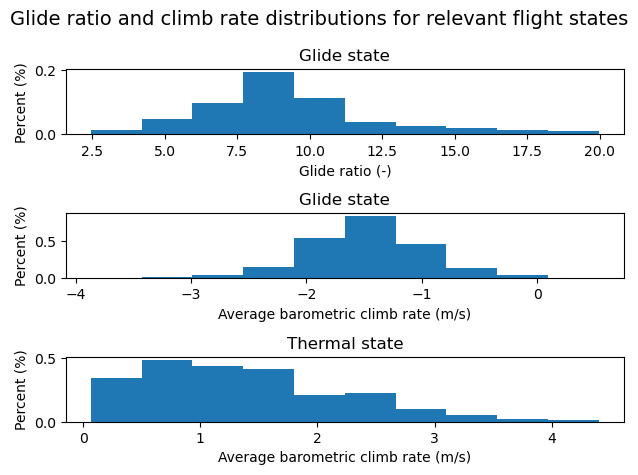

In [5]:
fig_cng,ax_cng = plt.subplots(3)
ax_cng[0].hist(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['glide_ratio'], density=True)
ax_cng[0].set_ylabel('Percent (%)')
ax_cng[0].set_xlabel('Glide ratio (-)')
ax_cng[0].set_title('Glide state')

ax_cng[1].hist(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['avg_baro_climb_rate'], density=True)
ax_cng[1].set_ylabel('Percent (%)')
ax_cng[1].set_xlabel('Average barometric climb rate (m/s)')
ax_cng[1].set_title('Glide state')

ax_cng[2].hist(df[df['flight_state']==2]['avg_baro_climb_rate'], density=True)
ax_cng[2].set_ylabel('Percent (%)')
ax_cng[2].set_xlabel('Average barometric climb rate (m/s)')
ax_cng[2].set_title('Thermal state')

fig_cng.suptitle('Glide ratio and climb rate distributions for relevant flight states', fontsize=14)
fig_cng.tight_layout()

### Gliding Polar Exploration
- Both plots seem to show the general shape that would be expected however, the values seem scattered on columns for respective ground speed bins. May be interesting to do a mean analysis for the corresponding sink rate and glide ratio value at each speed bin with corresponding uncertainty bands
- There appears to be a gap in data around 7 m/s which is close to approximate expected stall speed

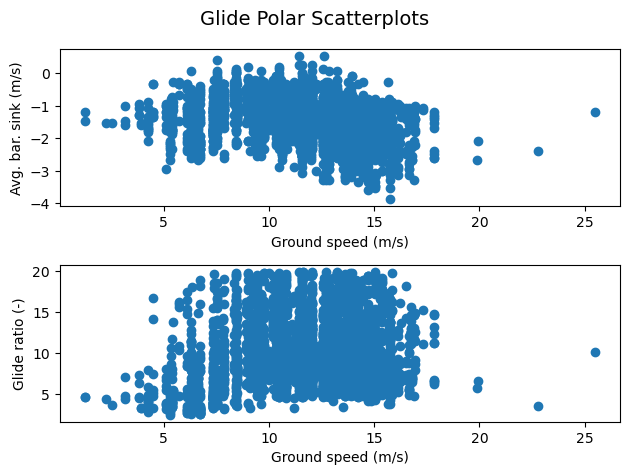

In [6]:
fig_polars,ax_polars = plt.subplots(2)

ax_polars[0].scatter(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['avg_baro_climb_rate'])
ax_polars[0].set_ylabel('Avg. bar. sink (m/s)')
ax_polars[0].set_xlabel('Ground speed (m/s)')

ax_polars[1].scatter(df[(df['flight_state']==1) & (df['glide_ratio']<20)]['ground_speed'],df[(df['flight_state']==1) & (df['glide_ratio']<20)]['glide_ratio'])
ax_polars[1].set_ylabel('Glide ratio (-)')
ax_polars[1].set_xlabel('Ground speed (m/s)')

fig_polars.suptitle('Glide Polar Scatterplots', fontsize=14)
fig_polars.tight_layout()

### Ground speed histogram

- Not sure that there is a signal for stall speed here but could be interesting to see with more data, potentially too noisy given air speed disparity

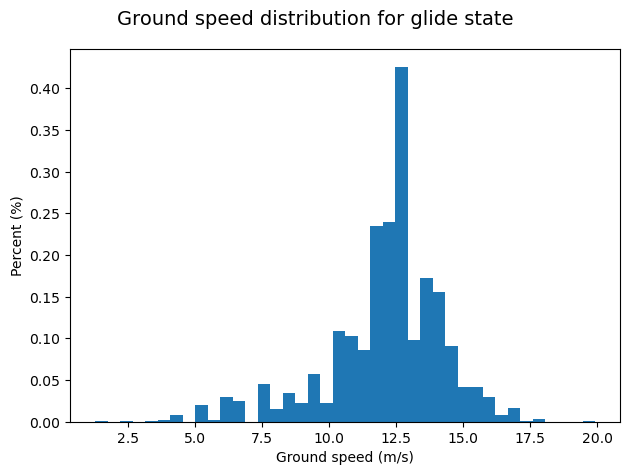

In [7]:
fig_gspd,ax_gspd = plt.subplots()

ax_gspd.hist(df[(df['flight_state']==1) & (df['glide_ratio']<20) & (df['ground_speed']<20)]['ground_speed'],bins=40,density=True)
ax_gspd.set_ylabel('Percent (%)')
ax_gspd.set_xlabel('Ground speed (m/s)')

fig_gspd.suptitle('Ground speed distribution for glide state', fontsize=14)
fig_gspd.tight_layout()

### Sanity check: plot the track and color based on flight state
- No surprises. There is likey room for improvement of the state definitions but at a first glance, seems appropriate for intended analysis

In [8]:
fig_track = go.Figure()

fig_track.add_trace(
    go.Scatter3d(
        x=df['longitude'],  # Longitude on X-axis
        y=df['latitude'],   # Latitude on Y-axis
        z=df['gps_altitude'],   # Altitude on Z-axis
        # mode='lines+markers',  # Show both line and markers
        marker=dict(size=3, color=df['flight_state'], colorscale='Inferno', showscale=True),
        # line=dict(color='blue', width=2),
        name='Flight Track'
    )
)

# Update layout for better visualization
fig_track.update_layout(
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Altitude (m)'
    ),
    title='3D IGC Track Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig_track.show()

### Climb rate vs. Rate of Turn exploration

Text(0, 0.5, 'Climb Rate (m/s)')

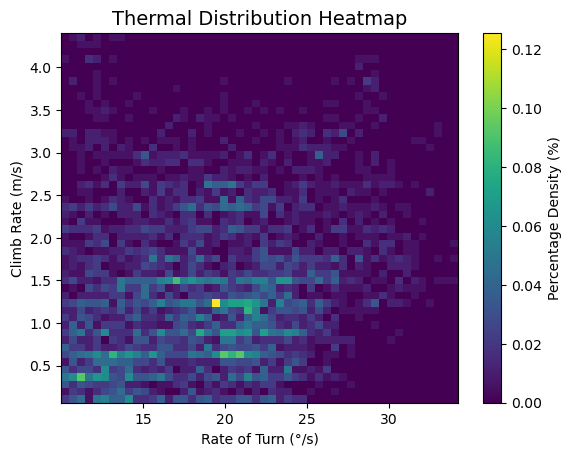

In [ ]:
heatmap, xedges, yedges = np.histogram2d(df[(df['flight_state']==2)]['avg_heading_roc'].abs(),df[(df['flight_state']==2)]['avg_baro_climb_rate'], bins=50, density=True)

fig_raw_thermal = plt.hist2d(df[(df['flight_state']==2)]['avg_heading_roc'].abs(),df[(df['flight_state']==2)]['avg_baro_climb_rate'], bins=50, cmap='viridis', density=True)

plt.colorbar(label='Percentage Density (%)')
plt.title('Thermal Distribution Heatmap', fontsize=14)
plt.xlabel('Average Rate of Turn (°/s)')
plt.ylabel('Climb Rate (m/s)')

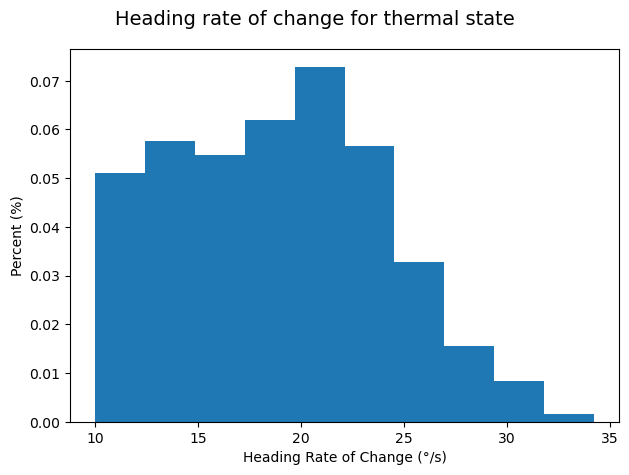

In [21]:
fig_roc_th,ax_roc_th = plt.subplots()

ax_roc_th.hist(df[(df['flight_state']==2)]['avg_heading_roc'].abs(),density=True)
ax_roc_th.set_ylabel('Percent (%)')
ax_roc_th.set_xlabel('Heading Rate of Change (°/s)')

fig_roc_th.suptitle('Heading rate of change for thermal state, global', fontsize=14)
fig_roc_th.tight_layout()

In [38]:
# thermal_id, height_gain, avg_turn_rate, avg_climb_rate
thermal_calc_df = df[df['flight_state']==2][['gps_altitude','baro_altitude','heading_roc','gps_climb_rate','baro_climb_rate',]]
thermal_calc_df

,gps_altitude,baro_altitude,heading_roc,gps_climb_rate,baro_climb_rate
61,1974.0,2120.0,-20.013497,1.0,1.0
62,1974.0,2120.0,-29.358291,0.0,0.0
63,1973.0,2119.0,-21.686844,-1.0,-1.0
64,1972.0,2119.0,-18.941423,-1.0,0.0
65,1972.0,2118.0,-6.525995,0.0,-1.0
...,...,...,...,...,...
11803,2283.0,2447.0,8.289764,0.0,1.0
11804,2284.0,2449.0,-0.000012,1.0,2.0
11805,2286.0,2451.0,9.195873,2.0,2.0
11806,2289.0,2454.0,-9.195866,3.0,3.0


In [ ]:
# Turn extraction first, then thermal extraction
# A turn has to be completed in consistent heading direction

# Rethink using just one row at a time so I can flag the start: for row in df.itertuples(index=True, name='Row'):
for current_row, next_row in zip(thermal_calc_df.itertuples(index=True), thermal_calc_df.itertuples(index=True, name='NextRow')):
    # Check if still in same thermal
    if (next_row.Index - current_row.Index == 1) :
        continue

    # Otherwise, start a new thermal
    else : #start a new thermal
        # flag starting index

        # run following computations after index breakage
        running_sum_hdg =+ current_row.heading_roc
        running_sum_baro_climb =+ current_row.baro_climb_rate 
        running_sum_gps_climb =+ current_row.gps_climb_rate
    print(f"Current: Index {current_row.Index}, A: {current_row.A}, B: {current_row.B}")
    print(f"Next: Index {next_row.Index}, A: {next_row.A}, B: {next_row.B}")

In [18]:
# TODO: Histogram of RoC Heading for thermal state
# TODO: Per turn basis, calculate Rate of Turn, and climb rate
# TODO: Per thermal basis calculate rate of turn and climb rate 
# TODO: Plot scatter plots of climb rate vs. RoT per bin, thermal, and turn 
# TODO: Explore left vs. right distribution of thermals

### Mean statistical analysis for ground speed bins

In [23]:
# TODO: extraction of the mean for each ground speed bin for glide ratio and sink rate to draw a statistical polar based on statistical mean sampling theorem



### General Statistical Exploration


In [24]:
# TODO: use .describe method

### Feature Engineering

In [12]:
# TODO: define features from metrics writeups (climb to distance ratio etc.)

### Figures

In [13]:
# TODO: plot scatter plots of climb rate vs. RoT per thermal (and see how that compares to histogram of heading RoC distr. between right and left as well)
# TODO: plot histogram of heading_roc
# TODO: plot histogram of glide_ratio
# TODO: plot scatterplot of climb_rate in glide vs. ground speed in glide

# Writeup

Thoughts:
- Importance of sourcing actual XC flights to avoid introducing bias into the data, worth sourcing what that means (e.g. 50km at minimum 15km/h)

In [14]:
# TODO: analyze all my tracks and generate a report with thermalling, gliding, and climbing statistics 
# BONUS: Include tracks from Chrigel or other high performing pilot

# Outputs

In [15]:
# TODO: dataframe for thermal and glide flight state data
# TODO: dataframe for thermal counter
# TODO: dataframe for enhanced xcontest_dashboard